# Snake

In [15]:
# Environments
import environments_fully_observable 
import environments_partially_observable

# Utilities
import numpy as np
import pickle
from tqdm import trange
from tqdm import tqdm
from dataclasses import dataclass
from typing import Tuple
from collections import deque
import random
import os

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Visualization
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd

# Seed for reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# Check for GPU availability (CUDA for Nvidia, MPS for Mac M4)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"✅ GPU Found: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✅ MPS (Metal Performance Shaders) Found: Apple Silicon Acceleration enabled.")
else:
    device = torch.device("cpu")
    print("❌ No GPU Found. Using CPU.")

✅ GPU Found: NVIDIA GeForce RTX 5050 Laptop GPU


## Environment definition

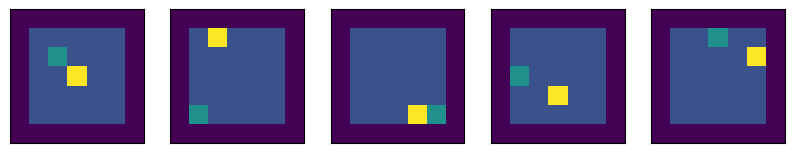

In [16]:
%matplotlib inline
# function to standardize getting an env for the whole notebook
def get_env(n=1000):
    # n is the number of boards that you want to simulate parallely
    # size is the size of each board, also considering the borders
    # mask for the partially observable, is the size of the local neighborhood
    size = 7
    e = environments_fully_observable.OriginalSnakeEnvironment(n, size)
    # or environments_partially_observable.OriginalSnakeEnvironment(n, size, 2)
    return e

env_ = get_env()

fig, axs = plt.subplots(1, min(len(env_.boards), 5), figsize=(10,3))
for ax, board in zip(axs, env_.boards):
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.imshow(board, origin="lower")
    

# Useful for future experiments if we want to change the number of (parallel) boards and their size 
# in the training loop without having to change the environment code

NUM_BOARDS = 1000
BOARD_SIZE = 7
ITERATIONS = 20_000_000   # Total training steps (a lot, but we use torch and GPU support for this reason!)

# Full Environment wrapper
def make_env(n_boards, board_size):
    return environments_fully_observable.OriginalSnakeEnvironment(n_boards,board_size)

In [17]:
# Safety mask fuction: checks for unsafe moves for all boards
def get_safety_mask(env):
    masks = np.zeros((env.n_boards, 4), dtype=np.float32)
    heads = np.argwhere(env.boards == env.HEAD)
    heads = heads[heads[:, 0].argsort()]

    moves = {0:(1,0), 1:(0,1), 2:(-1,0), 3:(0,-1)}

    for b, hx, hy in heads:
        for a, (dx, dy) in moves.items():
            nx, ny = hx+dx, hy+dy
            if env.boards[b, nx, ny] == env.WALL:
                masks[b, a] = 1.0   # unsafe for wall
    return torch.tensor(masks, device=device)

# Models

## PPO Agent

In [18]:
# Define the PPO Actor-Critic Network
class PPOActorCritic(nn.Module):
    def __init__(self, board_size=7, n_channels=4, n_actions=4):
        super().__init__()

        self.conv1 = nn.Conv2d(n_channels, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        self.board_size = board_size
        conv_out_dim = 128 * board_size * board_size

        self.fc = nn.Linear(conv_out_dim, 128)
        self.policy_head = nn.Linear(128, n_actions)
        self.value_head = nn.Linear(128, 1)

    def forward(self, x) -> Tuple[torch.Tensor, torch.Tensor]:
        x = x.permute(0, 3, 1, 2)          # (N, H, W, C) -> (N, C, H, W)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc(x))

        logits = self.policy_head(x)
        value = self.value_head(x).squeeze(-1)
        return logits, value

    def act(self, x, mask=None):
        logits, value = self.forward(x)
        if mask is not None:
            logits = logits + mask
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()
        logprob = dist.log_prob(action)
        return action, logprob, value


    def evaluate_actions(self, x, actions):
        logits, values = self.forward(x)
        dist = torch.distributions.Categorical(logits=logits)
        logprobs = dist.log_prob(actions)
        entropy = dist.entropy()
        return logprobs, entropy, values


In [19]:
# Define the Rollout Buffer for PPO
@dataclass
class RolloutBuffer:
    obs: list
    actions: list
    logprobs: list
    rewards: list
    values: list

    def __init__(self):
        self.obs = []
        self.actions = []
        self.logprobs = []
        self.rewards = []
        self.values = []

    def add(self, obs, action, logprob, reward, value):
        # obs, reward, value, logprob, action are numpy or scalars
        self.obs.append(obs)
        self.actions.append(action)
        self.logprobs.append(logprob)
        self.rewards.append(reward)
        self.values.append(value)

    def to_tensors(self):
        # conver all to torch tensors
        obs = torch.tensor(np.array(self.obs), dtype=torch.float32, device=device)
        actions = torch.tensor(np.array(self.actions), dtype=torch.long, device=device)
        logprobs = torch.tensor(np.array(self.logprobs), dtype=torch.float32, device=device)
        rewards = torch.tensor(np.array(self.rewards), dtype=torch.float32, device=device)
        values = torch.tensor(np.array(self.values), dtype=torch.float32, device=device)
        return obs, actions, logprobs, rewards, values

# Define the GAE computation
def compute_gae(rewards, values, last_value, gamma=0.99, lam=0.95):
    T, N = rewards.shape
    advantages = torch.zeros(T, N, device=device)
    gae = torch.zeros(N, device=device)

    for t in reversed(range(T)):
        next_value = last_value if t == T - 1 else values[t + 1]
        delta = rewards[t] + gamma * next_value - values[t]
        gae = delta + gamma * lam * gae
        advantages[t] = gae

    returns = advantages + values
    return advantages, returns


In [25]:
# Define the PPO Agent class:
class PPOAgent:
    def __init__(
        self,
        board_size=7,
        n_actions=4,
        lr=4e-4,
        gamma=0.9995,
        lam=0.95,
        clip_eps=0.2,
        epochs=4,
        batch_size=1024,
        ent_coef=0.05,   
    ):
        self.gamma = gamma
        self.lam = lam
        self.clip_eps = clip_eps
        self.epochs = epochs
        self.batch_size = batch_size
        self.ent_coef = ent_coef
        self.ent_coef_initial = ent_coef

        self.net = PPOActorCritic(board_size=board_size, n_channels=4, n_actions=n_actions).to(device)
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr)

    def update(self, buffer: RolloutBuffer, last_value):
        # Move last_value to device
        last_value = last_value.to(device)

        obs, actions, old_logprobs, rewards, values = buffer.to_tensors()

        # obs: (T, N, H, W, C)
        T, N = rewards.shape
        obs = obs.view(T * N, *obs.shape[2:])
        actions = actions.view(T * N)
        old_logprobs = old_logprobs.view(T * N)
        rewards = rewards.view(T, N)
        values = values.view(T, N)
        last_value = last_value.view(N)

        advantages, returns = compute_gae(
            rewards, values, last_value,
            gamma=self.gamma, lam=self.lam
        )

        advantages = advantages.view(T * N)
        returns = returns.view(T * N)

        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # PPO update
        dataset_size = T * N
        idxs = np.arange(dataset_size)

        total_policy_loss = 0.0
        total_value_loss = 0.0
        total_entropy = 0.0
        total_loss = 0.0
        batches = 0

        for _ in range(self.epochs):
            np.random.shuffle(idxs)
            for start in range(0, dataset_size, self.batch_size):
                end = start + self.batch_size
                batch_idx = idxs[start:end]

                # we select the batch and compute the losses
                batch_obs = obs[batch_idx]
                batch_actions = actions[batch_idx]
                batch_old_logprobs = old_logprobs[batch_idx]
                batch_adv = advantages[batch_idx]
                batch_returns = returns[batch_idx]

                logprobs, entropy, values_pred = self.net.evaluate_actions(batch_obs, batch_actions)

                ratio = torch.exp(logprobs - batch_old_logprobs)
                surr1 = ratio * batch_adv
                surr2 = torch.clamp(ratio, 1.0 - self.clip_eps, 1.0 + self.clip_eps) * batch_adv
                policy_loss = -torch.min(surr1, surr2).mean()

                value_loss = F.mse_loss(values_pred, batch_returns)

                loss = policy_loss + 0.5 * value_loss - self.ent_coef * entropy.mean()

                self.optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(self.net.parameters(), 0.5)
                self.optimizer.step()

                # accumulate 
                total_policy_loss += policy_loss.item() 
                total_value_loss += value_loss.item() 
                total_entropy += entropy.mean().item() 
                total_loss += loss.item() 
                batches += 1
        return { 
            "policy_loss": total_policy_loss / batches, 
            "value_loss": total_value_loss / batches, 
            "entropy": total_entropy / batches, 
            "total_loss": total_loss / batches, 
        }


In [26]:
# Training loop PPO
def train_ppo(total_steps=2_000_000, n_boards=256, board_size=7, rollout_horizon=256):
    env = make_env(n_boards=n_boards, board_size=board_size)
    agent = PPOAgent(board_size=board_size)

    state = env.to_state()
    step_count = 0

    reward_history = []
    fruits_history = []
    wall_deaths_history = []
    loss_history = []

    last_log_step = 0
    log_interval = 500000

    pbar = tqdm(total=total_steps, desc="Training PPO")
    while step_count < total_steps:
        buffer = RolloutBuffer()

        # Rollout collection
        for t in range(rollout_horizon):
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device)
            mask_tensor = get_safety_mask(env)
            penalty = -1.0

            with torch.no_grad():
                logits, values = agent.net.forward(state_tensor)
                logits = logits + penalty * mask_tensor
                dist = torch.distributions.Categorical(logits=logits)
                actions = dist.sample()
                logprobs = dist.log_prob(actions)

            actions_np = actions.cpu().numpy().reshape(-1, 1)
            rewards_tensor = env.move(actions_np)
            rewards_np = rewards_tensor.cpu().numpy().flatten()

            next_state = env.to_state()

            # metrics
            reward_history.append(np.mean(rewards_np))
            fruits_history.append(np.sum(rewards_np == env.FRUIT_REWARD))
            wall_deaths_history.append(np.sum(rewards_np == env.HIT_WALL_REWARD))

            buffer.add(
                obs=state,
                action=actions_np.squeeze(-1),
                logprob=logprobs.cpu().numpy(),
                reward=rewards_np,
                value=values.cpu().numpy()
            )

            state = next_state
            step_count += n_boards
            pbar.update(n_boards)

            if step_count >= total_steps:
                break

        # PPO update
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device)
        with torch.no_grad():
            _, last_values = agent.net.forward(state_tensor)

        loss_dict = agent.update(buffer, last_values) 
        loss_history.append(loss_dict)

        # Entropy decay
        progress = step_count / total_steps
        agent.ent_coef = agent.ent_coef_initial * (1 - progress)

        # Logging every 50k steps
        if step_count - last_log_step >= log_interval:
            last_log_step = step_count

            avg_reward = np.mean(reward_history[-500:])
            avg_fruits = np.mean(fruits_history[-500:])
            avg_deaths = np.mean(wall_deaths_history[-500:])

            avg_policy_loss = np.mean([l["policy_loss"] for l in loss_history[-50:]])
            avg_value_loss = np.mean([l["value_loss"] for l in loss_history[-50:]])
            avg_entropy = np.mean([l["entropy"] for l in loss_history[-50:]])
            avg_total_loss = np.mean([l["total_loss"] for l in loss_history[-50:]])

            tqdm.write(
                f"\nSteps: {step_count:,}"
                f"\n  Reward (last 500): {avg_reward:.3f}"
                f"\n  Fruits (last 500): {avg_fruits:.2f}"
                f"\n  Deaths (last 500): {avg_deaths:.2f}"
                f"\n  Policy Loss (avg 50 updates): {avg_policy_loss:.4f}"
                f"\n  Value Loss  (avg 50 updates): {avg_value_loss:.4f}"
                f"\n  Entropy     (avg 50 updates): {avg_entropy:.4f}"
                f"\n  Total Loss  (avg 50 updates): {avg_total_loss:.4f}"
            )


    pbar.close()
    return agent, reward_history, fruits_history, wall_deaths_history, loss_history



In [27]:
# Train the PPO agent on NUM_BOARDS parallel boards
ppo_agent, ppo_reward_hist, ppo_fruits_hist, ppo_wall_hist, ppo_loss_hist = train_ppo(
    total_steps=ITERATIONS,
    n_boards=NUM_BOARDS,
    board_size=BOARD_SIZE,
    rollout_horizon=256
)

Training PPO:   3%|▎         | 528000/20000000 [00:26<1:24:07, 3857.73it/s]


Steps: 512,000
  Reward (last 500): -0.021
  Fruits (last 500): 15.93
  Deaths (last 500): 51.33
  Policy Loss (avg 50 updates): -0.0136
  Value Loss  (avg 50 updates): 0.0350
  Entropy     (avg 50 updates): 1.2768
  Total Loss  (avg 50 updates): -0.0596


Training PPO:   5%|▌         | 1029000/20000000 [00:52<1:59:07, 2654.32it/s]


Steps: 1,024,000
  Reward (last 500): -0.011
  Fruits (last 500): 2.61
  Deaths (last 500): 3.67
  Policy Loss (avg 50 updates): -0.0117
  Value Loss  (avg 50 updates): 0.0208
  Entropy     (avg 50 updates): 1.2144
  Total Loss  (avg 50 updates): -0.0609


Training PPO:   8%|▊         | 1550000/20000000 [01:18<1:16:53, 3999.54it/s]


Steps: 1,536,000
  Reward (last 500): -0.010
  Fruits (last 500): 0.24
  Deaths (last 500): 0.40
  Policy Loss (avg 50 updates): -0.0087
  Value Loss  (avg 50 updates): 0.0146
  Entropy     (avg 50 updates): 1.1823
  Total Loss  (avg 50 updates): -0.0587


Training PPO:  10%|█         | 2060000/20000000 [01:44<1:16:01, 3932.65it/s]


Steps: 2,048,000
  Reward (last 500): -0.010
  Fruits (last 500): 0.26
  Deaths (last 500): 0.06
  Policy Loss (avg 50 updates): -0.0071
  Value Loss  (avg 50 updates): 0.0115
  Entropy     (avg 50 updates): 1.1693
  Total Loss  (avg 50 updates): -0.0572


Training PPO:  13%|█▎        | 2568000/20000000 [02:10<1:45:51, 2744.67it/s]


Steps: 2,560,000
  Reward (last 500): -0.009
  Fruits (last 500): 1.93
  Deaths (last 500): 0.32
  Policy Loss (avg 50 updates): -0.0062
  Value Loss  (avg 50 updates): 0.0111
  Entropy     (avg 50 updates): 1.1654
  Total Loss  (avg 50 updates): -0.0557


Training PPO:  15%|█▌        | 3077000/20000000 [02:37<2:01:46, 2316.25it/s]


Steps: 3,072,000
  Reward (last 500): 0.002
  Fruits (last 500): 22.74
  Deaths (last 500): 3.79
  Policy Loss (avg 50 updates): -0.0069
  Value Loss  (avg 50 updates): 0.0254
  Entropy     (avg 50 updates): 1.1243
  Total Loss  (avg 50 updates): -0.0467


Training PPO:  18%|█▊        | 3594000/20000000 [03:06<1:38:13, 2783.81it/s]


Steps: 3,584,000
  Reward (last 500): 0.029
  Fruits (last 500): 80.52
  Deaths (last 500): 5.07
  Policy Loss (avg 50 updates): -0.0080
  Value Loss  (avg 50 updates): 0.0542
  Entropy     (avg 50 updates): 1.0340
  Total Loss  (avg 50 updates): -0.0288


Training PPO:  21%|██        | 4105000/20000000 [03:35<1:36:40, 2740.08it/s]


Steps: 4,096,000
  Reward (last 500): 0.051
  Fruits (last 500): 133.70
  Deaths (last 500): 0.88
  Policy Loss (avg 50 updates): -0.0082
  Value Loss  (avg 50 updates): 0.0702
  Entropy     (avg 50 updates): 0.9482
  Total Loss  (avg 50 updates): -0.0168


Training PPO:  23%|██▎       | 4615000/20000000 [04:05<1:42:28, 2502.03it/s]


Steps: 4,608,000
  Reward (last 500): 0.064
  Fruits (last 500): 164.34
  Deaths (last 500): 0.28
  Policy Loss (avg 50 updates): -0.0080
  Value Loss  (avg 50 updates): 0.0832
  Entropy     (avg 50 updates): 0.8760
  Total Loss  (avg 50 updates): -0.0065


Training PPO:  26%|██▌       | 5123000/20000000 [04:36<2:15:48, 1825.75it/s]


Steps: 5,120,000
  Reward (last 500): 0.073
  Fruits (last 500): 184.74
  Deaths (last 500): 0.22
  Policy Loss (avg 50 updates): -0.0076
  Value Loss  (avg 50 updates): 0.0953
  Entropy     (avg 50 updates): 0.8163
  Total Loss  (avg 50 updates): 0.0029


Training PPO:  28%|██▊       | 5639000/20000000 [05:07<1:42:23, 2337.49it/s]


Steps: 5,632,000
  Reward (last 500): 0.079
  Fruits (last 500): 200.51
  Deaths (last 500): 0.14
  Policy Loss (avg 50 updates): -0.0071
  Value Loss  (avg 50 updates): 0.1067
  Entropy     (avg 50 updates): 0.7652
  Total Loss  (avg 50 updates): 0.0115


Training PPO:  31%|███       | 6151000/20000000 [05:38<1:39:06, 2328.90it/s]


Steps: 6,144,000
  Reward (last 500): 0.085
  Fruits (last 500): 214.30
  Deaths (last 500): 0.09
  Policy Loss (avg 50 updates): -0.0067
  Value Loss  (avg 50 updates): 0.1175
  Entropy     (avg 50 updates): 0.7217
  Total Loss  (avg 50 updates): 0.0195


Training PPO:  33%|███▎      | 6663000/20000000 [06:09<1:44:42, 2122.80it/s]


Steps: 6,656,000
  Reward (last 500): 0.089
  Fruits (last 500): 225.39
  Deaths (last 500): 0.13
  Policy Loss (avg 50 updates): -0.0063
  Value Loss  (avg 50 updates): 0.1276
  Entropy     (avg 50 updates): 0.6837
  Total Loss  (avg 50 updates): 0.0269


Training PPO:  36%|███▌      | 7173000/20000000 [06:40<2:09:37, 1649.22it/s]


Steps: 7,168,000
  Reward (last 500): 0.093
  Fruits (last 500): 235.99
  Deaths (last 500): 0.12
  Policy Loss (avg 50 updates): -0.0059
  Value Loss  (avg 50 updates): 0.1371
  Entropy     (avg 50 updates): 0.6502
  Total Loss  (avg 50 updates): 0.0337


Training PPO:  38%|███▊      | 7685000/20000000 [07:11<2:03:49, 1657.65it/s]


Steps: 7,680,000
  Reward (last 500): 0.096
  Fruits (last 500): 243.62
  Deaths (last 500): 0.12
  Policy Loss (avg 50 updates): -0.0055
  Value Loss  (avg 50 updates): 0.1459
  Entropy     (avg 50 updates): 0.6200
  Total Loss  (avg 50 updates): 0.0400


Training PPO:  41%|████      | 8199000/20000000 [07:42<1:24:21, 2331.30it/s]


Steps: 8,192,000
  Reward (last 500): 0.099
  Fruits (last 500): 249.88
  Deaths (last 500): 0.07
  Policy Loss (avg 50 updates): -0.0052
  Value Loss  (avg 50 updates): 0.1551
  Entropy     (avg 50 updates): 0.5926
  Total Loss  (avg 50 updates): 0.0463


Training PPO:  44%|████▎     | 8711000/20000000 [08:13<1:20:46, 2329.28it/s]


Steps: 8,704,000
  Reward (last 500): 0.101
  Fruits (last 500): 254.06
  Deaths (last 500): 0.05
  Policy Loss (avg 50 updates): -0.0049
  Value Loss  (avg 50 updates): 0.1637
  Entropy     (avg 50 updates): 0.5679
  Total Loss  (avg 50 updates): 0.0521


Training PPO:  46%|████▌     | 9223000/20000000 [08:44<1:17:09, 2327.87it/s]


Steps: 9,216,000
  Reward (last 500): 0.102
  Fruits (last 500): 256.69
  Deaths (last 500): 0.08
  Policy Loss (avg 50 updates): -0.0046
  Value Loss  (avg 50 updates): 0.1702
  Entropy     (avg 50 updates): 0.5452
  Total Loss  (avg 50 updates): 0.0568


Training PPO:  49%|████▊     | 9730000/20000000 [09:15<1:43:51, 1648.19it/s]


Steps: 9,728,000
  Reward (last 500): 0.104
  Fruits (last 500): 260.03
  Deaths (last 500): 0.05
  Policy Loss (avg 50 updates): -0.0043
  Value Loss  (avg 50 updates): 0.1759
  Entropy     (avg 50 updates): 0.5244
  Total Loss  (avg 50 updates): 0.0610


Training PPO:  51%|█████     | 10244000/20000000 [09:46<1:38:19, 1653.60it/s]


Steps: 10,240,000
  Reward (last 500): 0.105
  Fruits (last 500): 261.68
  Deaths (last 500): 0.09
  Policy Loss (avg 50 updates): -0.0040
  Value Loss  (avg 50 updates): 0.1812
  Entropy     (avg 50 updates): 0.5053
  Total Loss  (avg 50 updates): 0.0649


Training PPO:  54%|█████▍    | 10758000/20000000 [10:17<1:10:18, 2190.79it/s]


Steps: 10,752,000
  Reward (last 500): 0.106
  Fruits (last 500): 264.20
  Deaths (last 500): 0.10
  Policy Loss (avg 50 updates): -0.0038
  Value Loss  (avg 50 updates): 0.1875
  Entropy     (avg 50 updates): 0.4875
  Total Loss  (avg 50 updates): 0.0691


Training PPO:  56%|█████▋    | 11269000/20000000 [10:48<1:31:36, 1588.57it/s]


Steps: 11,264,000
  Reward (last 500): 0.106
  Fruits (last 500): 264.78
  Deaths (last 500): 0.07
  Policy Loss (avg 50 updates): -0.0036
  Value Loss  (avg 50 updates): 0.1921
  Entropy     (avg 50 updates): 0.4712
  Total Loss  (avg 50 updates): 0.0725


Training PPO:  59%|█████▉    | 11779000/20000000 [11:20<1:23:09, 1647.76it/s]


Steps: 11,776,000
  Reward (last 500): 0.107
  Fruits (last 500): 264.89
  Deaths (last 500): 0.05
  Policy Loss (avg 50 updates): -0.0033
  Value Loss  (avg 50 updates): 0.1991
  Entropy     (avg 50 updates): 0.4563
  Total Loss  (avg 50 updates): 0.0769


Training PPO:  61%|██████▏   | 12294000/20000000 [11:51<55:37, 2308.67it/s]  


Steps: 12,288,000
  Reward (last 500): 0.107
  Fruits (last 500): 264.48
  Deaths (last 500): 0.14
  Policy Loss (avg 50 updates): -0.0031
  Value Loss  (avg 50 updates): 0.2043
  Entropy     (avg 50 updates): 0.4425
  Total Loss  (avg 50 updates): 0.0805


Training PPO:  64%|██████▍   | 12805000/20000000 [12:22<1:12:30, 1653.84it/s]


Steps: 12,800,000
  Reward (last 500): 0.108
  Fruits (last 500): 267.72
  Deaths (last 500): 0.07
  Policy Loss (avg 50 updates): -0.0028
  Value Loss  (avg 50 updates): 0.2094
  Entropy     (avg 50 updates): 0.4296
  Total Loss  (avg 50 updates): 0.0840


Training PPO:  67%|██████▋   | 13318000/20000000 [12:54<50:19, 2212.72it/s]  


Steps: 13,312,000
  Reward (last 500): 0.108
  Fruits (last 500): 268.53
  Deaths (last 500): 0.05
  Policy Loss (avg 50 updates): -0.0021
  Value Loss  (avg 50 updates): 0.2231
  Entropy     (avg 50 updates): 0.3830
  Total Loss  (avg 50 updates): 0.0940


Training PPO:  69%|██████▉   | 13827000/20000000 [13:25<1:02:09, 1655.05it/s]


Steps: 13,824,000
  Reward (last 500): 0.109
  Fruits (last 500): 270.18
  Deaths (last 500): 0.05
  Policy Loss (avg 50 updates): -0.0017
  Value Loss  (avg 50 updates): 0.2347
  Entropy     (avg 50 updates): 0.3414
  Total Loss  (avg 50 updates): 0.1024


Training PPO:  72%|███████▏  | 14340000/20000000 [13:56<57:18, 1646.10it/s]  


Steps: 14,336,000
  Reward (last 500): 0.109
  Fruits (last 500): 269.92
  Deaths (last 500): 0.05
  Policy Loss (avg 50 updates): -0.0014
  Value Loss  (avg 50 updates): 0.2495
  Entropy     (avg 50 updates): 0.3008
  Total Loss  (avg 50 updates): 0.1121


Training PPO:  74%|███████▍  | 14855000/20000000 [14:28<36:53, 2323.96it/s] 


Steps: 14,848,000
  Reward (last 500): 0.110
  Fruits (last 500): 270.01
  Deaths (last 500): 0.03
  Policy Loss (avg 50 updates): -0.0011
  Value Loss  (avg 50 updates): 0.2639
  Entropy     (avg 50 updates): 0.2592
  Total Loss  (avg 50 updates): 0.1217


Training PPO:  77%|███████▋  | 15368000/20000000 [15:00<33:54, 2277.26it/s] 


Steps: 15,360,000
  Reward (last 500): 0.110
  Fruits (last 500): 271.20
  Deaths (last 500): 0.02
  Policy Loss (avg 50 updates): -0.0009
  Value Loss  (avg 50 updates): 0.2757
  Entropy     (avg 50 updates): 0.2169
  Total Loss  (avg 50 updates): 0.1298


Training PPO:  79%|███████▉  | 15879000/20000000 [15:31<31:57, 2149.66it/s] 


Steps: 15,872,000
  Reward (last 500): 0.110
  Fruits (last 500): 271.01
  Deaths (last 500): 0.02
  Policy Loss (avg 50 updates): -0.0004
  Value Loss  (avg 50 updates): 0.2841
  Entropy     (avg 50 updates): 0.1837
  Total Loss  (avg 50 updates): 0.1360


Training PPO:  82%|████████▏ | 16388000/20000000 [16:02<36:28, 1650.73it/s] 


Steps: 16,384,000
  Reward (last 500): 0.110
  Fruits (last 500): 271.50
  Deaths (last 500): 0.05
  Policy Loss (avg 50 updates): 0.0005
  Value Loss  (avg 50 updates): 0.2910
  Entropy     (avg 50 updates): 0.1673
  Total Loss  (avg 50 updates): 0.1411


Training PPO:  84%|████████▍ | 16900000/20000000 [16:33<31:08, 1659.29it/s] 


Steps: 16,896,000
  Reward (last 500): 0.111
  Fruits (last 500): 272.05
  Deaths (last 500): 0.08
  Policy Loss (avg 50 updates): 0.0009
  Value Loss  (avg 50 updates): 0.2952
  Entropy     (avg 50 updates): 0.1564
  Total Loss  (avg 50 updates): 0.1442


Training PPO:  87%|████████▋ | 17415000/20000000 [17:04<18:28, 2331.73it/s] 


Steps: 17,408,000
  Reward (last 500): 0.111
  Fruits (last 500): 271.92
  Deaths (last 500): 0.06
  Policy Loss (avg 50 updates): 0.0014
  Value Loss  (avg 50 updates): 0.3070
  Entropy     (avg 50 updates): 0.1474
  Total Loss  (avg 50 updates): 0.1511


Training PPO:  90%|████████▉ | 17928000/20000000 [17:36<14:47, 2334.43it/s] 


Steps: 17,920,000
  Reward (last 500): 0.111
  Fruits (last 500): 271.94
  Deaths (last 500): 0.02
  Policy Loss (avg 50 updates): 0.0018
  Value Loss  (avg 50 updates): 0.3152
  Entropy     (avg 50 updates): 0.1388
  Total Loss  (avg 50 updates): 0.1560


Training PPO:  92%|█████████▏| 18440000/20000000 [18:07<11:07, 2335.53it/s] 


Steps: 18,432,000
  Reward (last 500): 0.111
  Fruits (last 500): 272.52
  Deaths (last 500): 0.03
  Policy Loss (avg 50 updates): 0.0022
  Value Loss  (avg 50 updates): 0.3190
  Entropy     (avg 50 updates): 0.1311
  Total Loss  (avg 50 updates): 0.1585


Training PPO:  95%|█████████▍| 18948000/20000000 [18:38<10:33, 1661.55it/s] 


Steps: 18,944,000
  Reward (last 500): 0.111
  Fruits (last 500): 273.14
  Deaths (last 500): 0.03
  Policy Loss (avg 50 updates): 0.0025
  Value Loss  (avg 50 updates): 0.3232
  Entropy     (avg 50 updates): 0.1238
  Total Loss  (avg 50 updates): 0.1613


Training PPO:  97%|█████████▋| 19463000/20000000 [19:09<03:49, 2336.25it/s] 


Steps: 19,456,000
  Reward (last 500): 0.111
  Fruits (last 500): 272.70
  Deaths (last 500): 0.03
  Policy Loss (avg 50 updates): 0.0028
  Value Loss  (avg 50 updates): 0.3336
  Entropy     (avg 50 updates): 0.1168
  Total Loss  (avg 50 updates): 0.1672


Training PPO: 100%|█████████▉| 19972000/20000000 [19:40<00:16, 1663.14it/s] 


Steps: 19,968,000
  Reward (last 500): 0.111
  Fruits (last 500): 272.93
  Deaths (last 500): 0.06
  Policy Loss (avg 50 updates): 0.0033
  Value Loss  (avg 50 updates): 0.3373
  Entropy     (avg 50 updates): 0.1104
  Total Loss  (avg 50 updates): 0.1698


Training PPO: 100%|██████████| 20000000/20000000 [19:42<00:00, 16919.88it/s]


## A2C

In [ ]:
# Advantage Actor-Critic (A2C) Agent
class A2CNet(nn.Module):
    def __init__(self, board_size=7, n_channels=4, n_actions=4):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(n_channels, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
        )
        flat = board_size * board_size * 64
        self.policy = nn.Linear(flat, n_actions)
        self.value = nn.Linear(flat, 1)

    def forward(self, x):
        x = x.permute(0,3,1,2)  # NHWC → NCHW
        x = self.conv(x)
        x = x.reshape(x.size(0), -1)
        return self.policy(x), self.value(x).squeeze(-1)


def train_a2c(total_steps=2_000_000, n_boards=NUM_BOARDS, board_size=7):
    env = make_env(n_boards=n_boards, board_size=board_size)
    net = A2CNet(board_size=board_size).to(device)
    optimizer = optim.Adam(net.parameters(), lr=1e-4)

    state = env.to_state()
    step_count = 0
    pbar = tqdm(total=total_steps, desc="Training A2C")

    gamma = 0.99

    # Logging buffers
    reward_history = []
    fruits_history = []
    deaths_history = []
    policy_loss_hist = []
    value_loss_hist = []
    entropy_hist = []

    last_log_step = 0
    log_interval = 750_000

    while step_count < total_steps:
        s = torch.tensor(state, dtype=torch.float32, device=device)

        # Forward pass
        logits, v_s = net(s)
        dist = torch.distributions.Categorical(logits=logits)
        a = dist.sample()

        # Step environment
        rewards = env.move(a.cpu().numpy().reshape(-1,1))
        r = rewards.cpu().numpy().flatten()
        next_state = env.to_state()

        # Bootstrap V(s')
        with torch.no_grad():
            s_next = torch.tensor(next_state, dtype=torch.float32, device=device)
            _, v_next = net(s_next)

        # TD error δ = r + γV(s') − V(s)
        r_t = torch.tensor(r, dtype=torch.float32, device=device)
        delta = r_t + gamma * v_next - v_s

        # Losses
        logprobs = dist.log_prob(a)
        policy_loss = -(logprobs * delta.detach()).mean()
        value_loss = delta.pow(2).mean()
        entropy = dist.entropy().mean()

        loss = policy_loss + 0.5 * value_loss - 0.05 * entropy

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update state
        state = next_state
        step_count += n_boards
        pbar.update(n_boards)

        # Store metrics
        reward_history.append(np.mean(r))
        fruits_history.append(np.sum(r == env.FRUIT_REWARD))
        deaths_history.append(np.sum(r == env.HIT_WALL_REWARD))
        policy_loss_hist.append(policy_loss.item())
        value_loss_hist.append(value_loss.item())
        entropy_hist.append(entropy.item())

        # Periodic logging
        if step_count - last_log_step >= log_interval:
            last_log_step = step_count
            tqdm.write(
                f"\nSteps: {step_count:,}"
                f"\n  Reward (last 500): {np.mean(reward_history[-500:]):.3f}"
                f"\n  Fruits (last 500): {np.mean(fruits_history[-500:]):.2f}"
                f"\n  Deaths (last 500): {np.mean(deaths_history[-500:]):.2f}"
                f"\n  Policy Loss (last 500): {np.mean(policy_loss_hist[-500:]):.4f}"
                f"\n  Value Loss  (last 500): {np.mean(value_loss_hist[-500:]):.4f}"
                f"\n  Entropy     (last 500): {np.mean(entropy_hist[-500:]):.4f}"
            )

    pbar.close()

    return net, reward_history, fruits_history, deaths_history


In [ ]:
a2c_agent, a2c_reward_hist, a2c_fruits_hist, a2c_deaths_hist = train_a2c(
    total_steps=ITERATIONS,
    n_boards=NUM_BOARDS,
    board_size=BOARD_SIZE
)

## DDQN

In [ ]:
# Double DQN Agent
class DDQNNet(nn.Module):
    def __init__(self, board_size=7, n_channels=4, n_actions=4):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(n_channels, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
        )
        flat = board_size * board_size * 64
        self.q_head = nn.Linear(flat, n_actions)

    def forward(self, x):
        x = x.permute(0,3,1,2)  # NHWC → NCHW
        x = self.conv(x)
        x = x.reshape(x.size(0), -1)
        return self.q_head(x)   # (B, n_actions)


class ReplayBuffer:
    def __init__(self, capacity=100_000):
        self.buffer = deque(maxlen=capacity)

    def push(self, s, a, r, s_next):
        self.buffer.append((s, a, r, s_next))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s_next = zip(*batch)
        return (
            torch.tensor(np.array(s), dtype=torch.float32, device=device),
            torch.tensor(np.array(a), dtype=torch.long, device=device),
            torch.tensor(np.array(r), dtype=torch.float32, device=device),
            torch.tensor(np.array(s_next), dtype=torch.float32, device=device),
        )

    def __len__(self):
        return len(self.buffer)


def train_ddqn(
    total_steps=2_000_000,
    n_boards=NUM_BOARDS,
    board_size=7,
    batch_size=256,
    gamma=0.99,
    lr=4e-4,
    start_learning=10_000,
    target_update_interval=5_000,
    eps_start=1.0,
    eps_end=0.05,
    eps_decay_steps=500_000,
):
    env = make_env(n_boards=n_boards, board_size=board_size)
    online = DDQNNet(board_size=board_size).to(device)
    target = DDQNNet(board_size=board_size).to(device)
    target.load_state_dict(online.state_dict())
    target.eval()

    optimizer = optim.Adam(online.parameters(), lr=lr)
    buffer = ReplayBuffer()

    state = env.to_state()
    step_count = 0
    pbar = tqdm(total=total_steps, desc="Training DDQN")

    rew_hist = []
    fruits_hist = []
    deaths_hist = []

    last_log_step = 0
    log_interval = 500_000

    def epsilon_by_step(t):
        frac = min(1.0, t / eps_decay_steps)
        return eps_start + frac * (eps_end - eps_start)

    while step_count < total_steps:
        s = state  # (N, H, W, C)
        eps = epsilon_by_step(step_count)

        # ε-greedy
        with torch.no_grad():
            q_values = online(torch.tensor(s, dtype=torch.float32, device=device))
            greedy_actions = torch.argmax(q_values, dim=-1).cpu().numpy()

        random_mask = np.random.rand(n_boards) < eps
        random_actions = np.random.randint(0, 4, size=n_boards)
        actions = np.where(random_mask, random_actions, greedy_actions).reshape(-1, 1)

        rewards = env.move(actions)
        r = rewards.cpu().numpy().flatten()
        next_state = env.to_state()

        # log per-step metrics
        rew_hist.append(np.mean(r))
        fruits_hist.append(np.sum(r == env.FRUIT_REWARD))
        deaths_hist.append(np.sum(r == env.HIT_WALL_REWARD))

        # push transitions (per board) in buffer
        for i in range(n_boards):
            buffer.push(s[i], actions[i, 0], r[i], next_state[i])

        state = next_state
        step_count += n_boards
        pbar.update(n_boards)

        # learn
        if len(buffer) >= start_learning:
            s_b, a_b, r_b, s_next_b = buffer.sample(batch_size)

            # Q(s,a)
            q = online(s_b).gather(1, a_b.view(-1,1)).squeeze(1)

            # Double DQN target
            with torch.no_grad():
                online_next = online(s_next_b)
                best_actions = torch.argmax(online_next, dim=-1, keepdim=True)
                target_next = target(s_next_b).gather(1, best_actions).squeeze(1)
                y = r_b + gamma * target_next

            loss = F.mse_loss(q, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # target update
        if step_count % target_update_interval < n_boards:
            target.load_state_dict(online.state_dict())

        # logging
        if step_count - last_log_step >= log_interval:
            last_log_step = step_count
            tqdm.write(
                f"\nSteps: {step_count:,}"
                f"\n  Reward (last 500): {np.mean(rew_hist[-500:]):.3f}"
                f"\n  Fruits (last 500): {np.mean(fruits_hist[-500:]):.2f}"
                f"\n  Deaths (last 500): {np.mean(deaths_hist[-500:]):.2f}"
                f"\n  Epsilon: {eps:.3f}"
            )

    pbar.close()
    return online, rew_hist, fruits_hist, deaths_hist

In [ ]:
ddqn_agent, ddqn_rew_hist, ddqn_fruits_hist, ddqn_deaths_hist = train_ddqn(
    total_steps = ITERATIONS,
    n_boards = NUM_BOARDS,
    board_size = BOARD_SIZE
)

## Training Result Savings
### Skip this cell
This has to be executed only once since it packs all the training results and the weights of the networks.

In [ ]:
def save_training_results(
    algo_name,
    model,
    reward_hist,
    fruits_hist,
    deaths_hist,
    extra_metrics=None,
    params=None,
    save_dir="results"
):

    algo_dir = os.path.join(save_dir, algo_name)
    os.makedirs(algo_dir, exist_ok=True)

    # Detect the actual PyTorch model inside the agent
    if hasattr(model, "state_dict"):
        # A2C or DDQN (the model itself is a nn.Module)
        torch_model = model
    elif hasattr(model, "net"):
        # PPOAgent: the neural network is inside .net
        torch_model = model.net
    else:
        raise ValueError(f"Cannot find a PyTorch model inside {algo_name} agent")

    # Save weights
    torch.save(torch_model.state_dict(), os.path.join(algo_dir, f"{algo_name}_weights.pt"))

    # Save training data
    data = {
        "reward_hist": reward_hist,
        "fruits_hist": fruits_hist,
        "deaths_hist": deaths_hist,
        "params": params or {},
    }

    if extra_metrics is not None:
        data.update(extra_metrics)

    with open(os.path.join(algo_dir, f"{algo_name}_training.pkl"), "wb") as f:
        pickle.dump(data, f)

    print(f"Saved {algo_name} results in {algo_dir}")

# PPO
params = {
    "lr": 3e-4,
    "gamma": 0.99,
    "n_boards": NUM_BOARDS,
    "board_size": BOARD_SIZE,
    "total_steps": ITERATIONS,
}
save_training_results(
    algo_name="ppo",
    model=agent,
    reward_hist=rew_hist,
    fruits_hist=fruits_hist,
    deaths_hist=wall_hist,
    extra_metrics={"loss_hist": loss_hist},
    params=params
)

# A2C
save_training_results(
    algo_name="a2c",
    model=a2c_agent,
    reward_hist=a2c_reward_hist,
    fruits_hist=a2c_fruits_hist,
    deaths_hist=a2c_deaths_hist,
    params=params
)

# DDQN
save_training_results(
    algo_name="ddqn",
    model=ddqn_agent,
    reward_hist=ddqn_rew_hist,
    fruits_hist=ddqn_fruits_hist,
    deaths_hist=ddqn_deaths_hist,
    params=params
)



# Evaluation

## Baseline

In [28]:
# BASELINE POLICY
# Acts greedily toward the fruit and checks for walls and body. In case of no safe moves, it chooses randomly among all possible actions. 

def baseline_policy(env):
    n = env.n_boards
    actions = np.zeros((n, 1), dtype=np.int32)

    heads = np.argwhere(env.boards == env.HEAD)
    fruits = np.argwhere(env.boards == env.FRUIT)

    heads = heads[heads[:, 0].argsort()]
    fruits = fruits[fruits[:, 0].argsort()]

    moves = {
        env.UP:    (1, 0),
        env.DOWN:  (-1, 0),
        env.RIGHT: (0, 1),
        env.LEFT:  (0, -1)
    }

    for i in range(n):
        _, hx, hy = heads[i]
        _, fx, fy = fruits[i]

        # greedy direction toward fruit
        if fx > hx: a = env.UP
        elif fx < hx: a = env.DOWN
        elif fy > hy: a = env.RIGHT
        elif fy < hy: a = env.LEFT
        else: a = env.UP

        # compute next head position
        dx, dy = moves[a]
        nx, ny = hx + dx, hy + dy

        # check BODY or WALL
        if env.boards[i, nx, ny] in (env.BODY, env.WALL):
            safe = []
            for act, (dx, dy) in moves.items():
                tx, ty = hx + dx, hy + dy
                if env.boards[i, tx, ty] not in (env.BODY, env.WALL):
                    safe.append(act)

            if len(safe) == 0:
                a = np.random.choice([env.UP, env.DOWN, env.LEFT, env.RIGHT])
            else:
                a = np.random.choice(safe)

        actions[i] = a

    return actions

In [ ]:
# Evaluation functions

# Evaluate the baseline policy
def evaluate_baseline(steps=1000):
    env = get_env(n=NUM_BOARDS)
    fruits = []
    deaths = []
    reward_means = []

    for _ in range(steps):
        actions = baseline_policy(env)
        rewards = env.move(actions)
        rewards = rewards.numpy().flatten() if hasattr(rewards, "numpy") else rewards

        # metriche
        fruits.append(np.sum(rewards == env.FRUIT_REWARD))
        deaths.append(np.sum(rewards == env.HIT_WALL_REWARD))
        reward_means.append(np.mean(rewards))

    return (
        np.mean(np.array(fruits)),
        np.mean(np.array(deaths)),
        np.mean(np.array(reward_means))
    )

# Evaluate agent
def evaluate_agent(agent, steps=1000):
    env = get_env(n=NUM_BOARDS)
    fruits = []
    deaths = []
    rewards_mean = []

    for _ in range(steps):
        state = env.to_state()
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device)

        with torch.no_grad():

            # PPO agent → has .net
            if hasattr(agent, "net"):
                logits, _ = agent.net(state_tensor)
                dist = torch.distributions.Categorical(logits=logits)
                actions = dist.sample().cpu().numpy().reshape(-1, 1)

            else:
                # A2C or DDQN
                out = agent(state_tensor)

                # A2C returns (logits, value)
                if isinstance(out, tuple):
                    logits, _ = out
                    dist = torch.distributions.Categorical(logits=logits)
                    actions = dist.sample().cpu().numpy().reshape(-1, 1)

                else:
                    # DDQN returns Q-values
                    q_values = out
                    actions = torch.argmax(q_values, dim=-1).cpu().numpy().reshape(-1, 1)

        rewards = env.move(actions).cpu().numpy().flatten()

        fruits.append(np.sum(rewards == env.FRUIT_REWARD))
        deaths.append(np.sum(rewards == env.HIT_WALL_REWARD))
        rewards_mean.append(np.mean(rewards))

    return (
        np.array(fruits),
        np.array(deaths),
        np.array(rewards_mean)
    )

# *****CUT BELOW*****
# Evaluation steps
eval_steps = 100
print("Evaluation over", eval_steps, "steps per agent, using the full trained models.")

# Evaluate Baseline
baseline_fruits_avg, baseline_wall_avg, baseline_reward_avg = evaluate_baseline(eval_steps)

# Evaluate PPO
ppo_fruits_eval, ppo_wall_eval, ppo_reward_eval = evaluate_agent(ppo_agent, eval_steps)

window = 200
kernel = np.ones(window) / window

# PPO moving averages
ppo_reward_moving = np.convolve(ppo_reward_hist, kernel, mode='valid')
ppo_fruits_moving = np.convolve(ppo_fruits_hist, kernel, mode='valid')
ppo_wall_moving = np.convolve(ppo_wall_hist, kernel, mode='valid')

Evaluation over 100 steps per agent, using the full trained models.


### Load the data (weights and training history)
Execute this cell only if training has been already done (for all models).

In [ ]:
# Load Weights
ppo_agent = PPOAgent(board_size=BOARD_SIZE)
ppo_agent.net.load_state_dict(torch.load("results/ppo/ppo_weights.pt"))

a2c_agent = A2CNet(board_size=BOARD_SIZE).to(device)
a2c_agent.load_state_dict(torch.load("results/a2c/a2c_weights.pt"))

ddqn_agent = DDQNNet(board_size=BOARD_SIZE).to(device)
ddqn_agent.load_state_dict(torch.load("results/ddqn/ddqn_weights.pt"))

# Load training data

with open("results/ppo/ppo_training.pkl", "rb") as f:
    ppo_data = pickle.load(f)

ppo_reward_hist = ppo_data["reward_hist"]
ppo_fruits_hist = ppo_data["fruits_hist"]
ppo_wall_hist = ppo_data["deaths_hist"]

with open("results/a2c/a2c_training.pkl", "rb") as f:
    a2c_data = pickle.load(f)

a2c_reward_hist = a2c_data["reward_hist"]
a2c_fruits_hist = a2c_data["fruits_hist"]
a2c_wall_hist = a2c_data["deaths_hist"]

with open("results/ddqn/ddqn_training.pkl", "rb") as f:
    ddqn_data = pickle.load(f)

ddqn_reward_hist = ddqn_data["reward_hist"]
ddqn_fruits_hist = ddqn_data["fruits_hist"]
ddqn_wall_hist = ddqn_data["deaths_hist"]

print("All data loaded successfully.")

In [ ]:
# To assess the performance after training, we evaluate the baseline and the PPO agent on 1000 steps and compare the average reward, fruits, and deaths. 

# Evaluation steps
eval_steps = 100
print("Evaluation over", eval_steps, "steps per agent, using the full trained models.")

# Evaluate Baseline
baseline_fruits_avg, baseline_wall_avg, baseline_reward_avg = evaluate_baseline(eval_steps)

# Evaluate PPO
ppo_fruits_eval, ppo_wall_eval, ppo_reward_eval = evaluate_agent(ppo_agent, eval_steps)

# Evaluate A2C
a2c_fruits_eval, a2c_wall_eval, a2c_reward_eval = evaluate_agent(a2c_agent, eval_steps)

# Evaluate DDQN
ddqn_fruits_eval, ddqn_wall_eval, ddqn_reward_eval = evaluate_agent(ddqn_agent, eval_steps)

# Build comparison table
df = pd.DataFrame({
    "Metric": ["Reward (Avg)", "Fruits (Avg)", "Wall hits (Avg)"],
    "PPO": [
        np.mean(ppo_reward_eval),
        np.mean(ppo_fruits_eval),
        np.mean(ppo_wall_eval)
    ],
    "A2C": [
        np.mean(a2c_reward_eval),
        np.mean(a2c_fruits_eval),
        np.mean(a2c_wall_eval)
    ],
    "DDQN": [
        np.mean(ddqn_reward_eval),
        np.mean(ddqn_fruits_eval),
        np.mean(ddqn_wall_eval)
    ],
    "Baseline": [
        baseline_reward_avg,
        baseline_fruits_avg,
        baseline_wall_avg
    ]
})

display(df)

In [ ]:
# EVALUATION DURING TRAINING OF PPO AND A2C AGENTS

window = 200
kernel = np.ones(window) / window

# PPO moving averages
ppo_reward_moving = np.convolve(ppo_reward_hist, kernel, mode='valid')
ppo_fruits_moving = np.convolve(ppo_fruits_hist, kernel, mode='valid')
ppo_wall_moving = np.convolve(ppo_wall_hist, kernel, mode='valid')

# A2C moving averages
a2c_reward_moving = np.convolve(a2c_reward_hist, kernel, mode='valid')
a2c_fruits_moving = np.convolve(a2c_fruits_hist, kernel, mode='valid')
a2c_wall_moving = np.convolve(a2c_wall_hist, kernel, mode='valid')

# DDQN moving averages
ddqn_reward_moving = np.convolve(ddqn_reward_hist, kernel, mode='valid')
ddqn_fruits_moving = np.convolve(ddqn_fruits_hist, kernel, mode='valid')
ddqn_wall_moving = np.convolve(ddqn_wall_hist, kernel, mode='valid')

In [ ]:
# ===============================
# FIGURE 1 — DDQN Training Curves
# ===============================

plt.figure(figsize=(15, 4))
plt.rcParams.update({'font.size': 12})

# DDQN – Reward
plt.subplot(1, 3, 1)
plt.plot(ddqn_reward_hist, color='lightblue', alpha=0.5, linewidth=1, label="Raw Reward")
plt.plot(ddqn_reward_moving, color='blue', linewidth=2.5, label="Moving Average")
plt.axhline(y=baseline_reward_avg, color='black', linestyle='--', linewidth=2, label="Baseline")
plt.title("DDQN – Reward per Step")
plt.xlabel("Training Step")
plt.ylabel("Reward")
plt.legend(fontsize='x-small')
plt.grid(True, alpha=0.3)

# DDQN – Fruits
plt.subplot(1, 3, 2)
plt.plot(ddqn_fruits_hist, color='lightgreen', alpha=0.5, linewidth=1, label="Raw Fruits")
plt.plot(ddqn_fruits_moving, color='green', linewidth=2.5, label="Moving Average")
plt.axhline(y=baseline_fruits_avg, color='black', linestyle='--', linewidth=2, label="Baseline")
plt.title("DDQN – Fruits per Step")
plt.xlabel("Training Step")
plt.ylabel("Fruits")
plt.legend(fontsize='x-small')
plt.grid(True, alpha=0.3)

# DDQN – Wall Collisions
plt.subplot(1, 3, 3)
plt.plot(ddqn_wall_hist, color='lightcoral', alpha=0.5, linewidth=1, label="Raw Collisions")
plt.plot(ddqn_wall_moving, color='red', linewidth=2.5, label="Moving Average")
plt.axhline(y=baseline_wall_avg, color='black', linestyle='--', linewidth=2, label="Baseline")
plt.title("DDQN – Wall Collisions per Step")
plt.xlabel("Training Step")
plt.ylabel("Wall Collisions")
plt.legend(fontsize='x-small')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("results/ddqn_training_curves.pdf", bbox_inches='tight')
plt.show()


In [ ]:
# ==============================
# FIGURE 2 — A2C Training Curves
# ==============================

plt.figure(figsize=(15, 4))
plt.rcParams.update({'font.size': 12})

# A2C – Reward
plt.subplot(1, 3, 1)
plt.plot(a2c_reward_hist, color='lightblue', alpha=0.5, linewidth=1, label="Raw Reward")
plt.plot(a2c_reward_moving, color='blue', linewidth=2.5, label="Moving Average")
plt.axhline(y=baseline_reward_avg, color='black', linestyle='--', linewidth=2, label="Baseline")
plt.title("A2C – Reward per Step")
plt.xlabel("Training Step")
plt.ylabel("Reward")
plt.legend(fontsize='x-small')
plt.grid(True, alpha=0.3)

# A2C – Fruits
plt.subplot(1, 3, 2)
plt.plot(a2c_fruits_hist, color='lightgreen', alpha=0.5, linewidth=1, label="Raw Fruits")
plt.plot(a2c_fruits_moving, color='green', linewidth=2.5, label="Moving Average")
plt.axhline(y=baseline_fruits_avg, color='black', linestyle='--', linewidth=2, label="Baseline")
plt.title("A2C – Fruits per Step")
plt.xlabel("Training Step")
plt.ylabel("Fruits")
plt.legend(fontsize='x-small')
plt.grid(True, alpha=0.3)

# A2C – Wall Collisions
plt.subplot(1, 3, 3)
plt.plot(a2c_wall_hist, color='lightcoral', alpha=0.5, linewidth=1, label="Raw Collisions")
plt.plot(a2c_wall_moving, color='red', linewidth=2.5, label="Moving Average")
plt.axhline(y=baseline_wall_avg, color='black', linestyle='--', linewidth=2, label="Baseline")
plt.title("A2C – Wall Collisions per Step")
plt.xlabel("Training Step")
plt.ylabel("Wall Collisions")
plt.legend(fontsize='x-small')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("results/a2c_training_curves.pdf", bbox_inches='tight')
plt.show()


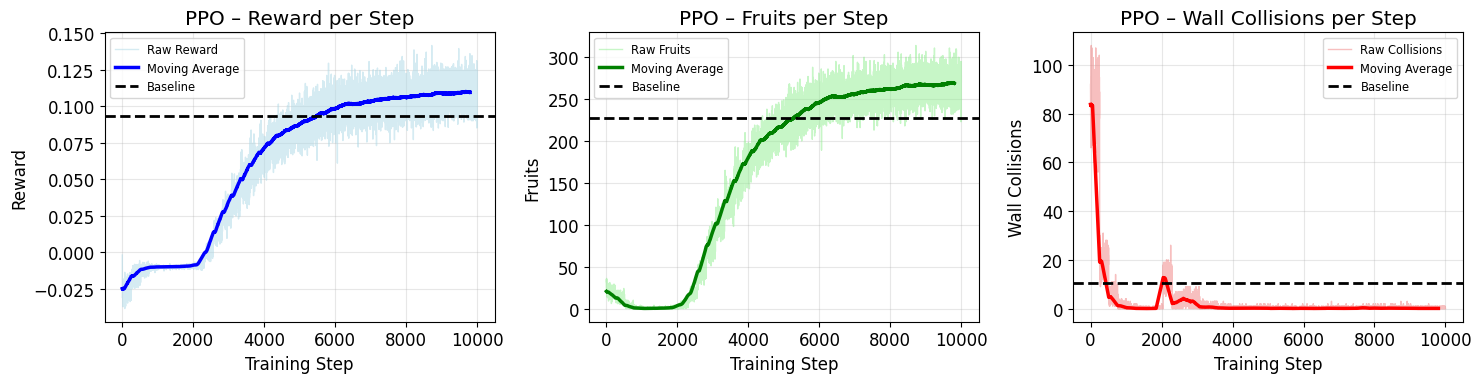

In [12]:
# ==============================
# FIGURE 3 — PPO Training Curves
# ==============================

plt.figure(figsize=(15, 4))
plt.rcParams.update({'font.size': 12})

# PPO – Reward
plt.subplot(1, 3, 1)
plt.plot(ppo_reward_hist, color='lightblue', alpha=0.5, linewidth=1, label="Raw Reward")
plt.plot(ppo_reward_moving, color='blue', linewidth=2.5, label="Moving Average")
plt.axhline(y=baseline_reward_avg, color='black', linestyle='--', linewidth=2, label="Baseline")
plt.title("PPO – Reward per Step")
plt.xlabel("Training Step")
plt.ylabel("Reward")
plt.legend(fontsize='x-small')
plt.grid(True, alpha=0.3)

# PPO – Fruits
plt.subplot(1, 3, 2)
plt.plot(ppo_fruits_hist, color='lightgreen', alpha=0.5, linewidth=1, label="Raw Fruits")
plt.plot(ppo_fruits_moving, color='green', linewidth=2.5, label="Moving Average")
plt.axhline(y=baseline_fruits_avg, color='black', linestyle='--', linewidth=2, label="Baseline")
plt.title("PPO – Fruits per Step")
plt.xlabel("Training Step")
plt.ylabel("Fruits")
plt.legend(fontsize='x-small')
plt.grid(True, alpha=0.3)

# PPO – Wall Collisions
plt.subplot(1, 3, 3)
plt.plot(ppo_wall_hist, color='lightcoral', alpha=0.5, linewidth=1, label="Raw Collisions")
plt.plot(ppo_wall_moving, color='red', linewidth=2.5, label="Moving Average")
plt.axhline(y=baseline_wall_avg, color='black', linestyle='--', linewidth=2, label="Baseline")
plt.title("PPO – Wall Collisions per Step")
plt.xlabel("Training Step")
plt.ylabel("Wall Collisions")
plt.legend(fontsize='x-small')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("results/ppo_training_curves.pdf", bbox_inches='tight')
plt.show()



In [ ]:
# FINAL COMPARISON PLOTS (PPO vs A2C vs DDQN)

plt.figure(figsize=(18, 10))
plt.rcParams.update({'font.size': 12})

# -----------------------------
# COMPARISON 1 — Reward
# -----------------------------
plt.subplot(3, 3, 1)
plt.plot(ppo_reward_moving, label="PPO", linewidth=2.5)
plt.plot(a2c_reward_moving, label="A2C", linewidth=2.5)
plt.plot(ddqn_reward_moving, label="DDQN", linewidth=2.5)
plt.axhline(y=baseline_reward_avg, color='black', linestyle='--', linewidth=2,
            label="Baseline")
plt.title("Reward per Step – Comparison")
plt.xlabel("Training Step")
plt.ylabel("Reward")
plt.legend()
plt.grid(True, alpha=0.3)

# -----------------------------
# COMPARISON 2 — Fruits
# -----------------------------
plt.subplot(3, 3, 2)
plt.plot(ppo_fruits_moving, label="PPO", linewidth=2.5)
plt.plot(a2c_fruits_moving, label="A2C", linewidth=2.5)
plt.plot(ddqn_fruits_moving, label="DDQN", linewidth=2.5)
plt.axhline(y=baseline_fruits_avg, color='black', linestyle='--', linewidth=2,
            label="Baseline")
plt.title("Fruits per Step – Comparison")
plt.xlabel("Training Step")
plt.ylabel("Fruits")
plt.legend()
plt.grid(True, alpha=0.3)

# -----------------------------
# COMPARISON 3 — Wall Collisions
# -----------------------------
plt.subplot(3, 3, 3)
plt.plot(ppo_wall_moving, label="PPO", linewidth=2.5)
plt.plot(a2c_wall_moving, label="A2C", linewidth=2.5)
plt.plot(ddqn_wall_moving, label="DDQN", linewidth=2.5)
plt.axhline(y=baseline_wall_avg, color='black', linestyle='--', linewidth=2, label="Baseline")
plt.title("Wall Collisions per Step – Comparison")
plt.xlabel("Training Step")
plt.ylabel("Wall Collisions")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("results/full_training_comparison.pdf", bbox_inches='tight')
plt.show()


### Play Snake with PPO Agent

In [13]:
def display_game(model, max_steps=100):
    game_env = get_env(n=1)
    state = game_env.to_state()
    frames = []

    frames.append(game_env.boards[0].copy())

    print("Generating animation...", end="")

    # Put model in eval mode
    if hasattr(model, "net"):      # PPOAgent
        model.net.eval()
    else:                          # A2CNet or DDQNNet
        model.eval()

    for _ in range(max_steps):
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device)

        mask = get_safety_mask(game_env)

        with torch.no_grad():

            if hasattr(model, "net"):   # PPO
                logits, _ = model.net(state_tensor)
                logits = logits + mask * -1.0
                actions = torch.argmax(logits, dim=1)

            else:
                out = model(state_tensor)

                if isinstance(out, tuple):   # A2C
                    logits, _ = out
                    logits = logits + mask * -1.0
                    actions = torch.argmax(logits, dim=1)

                else:                        # DDQN
                    q_values = out
                    actions = torch.argmax(q_values, dim=1)

        actions_np = actions.cpu().numpy().reshape(-1, 1)

        game_env.move(actions_np)
        state = game_env.to_state()

        frames.append(game_env.boards[0].copy())

    # -----------------------------------------
    # 1. STATIC SNAPSHOTS EVERY 15 STEPS
    # -----------------------------------------
    snapshot_steps = [0, 10, 20, 30, 40]
    snapshot_steps = [s for s in snapshot_steps if s < len(frames)]

    fig, axes = plt.subplots(1, len(snapshot_steps), figsize=(15, 3))

    for ax, step in zip(axes, snapshot_steps):
        ax.imshow(frames[step], origin='lower', cmap='viridis', vmin=0, vmax=4)
        ax.set_title(f"Step {step}")
        ax.axis('off')

    plt.show()

    # -----------------------------------------
    # 2. ANIMATION
    # -----------------------------------------
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.axis('off')

    img = ax.imshow(frames[0], origin='lower', cmap='viridis', vmin=0, vmax=4)
    ax.set_title("Snake Agent Replay")

    def update(frame):
        img.set_array(frame)
        return [img]

    ani = animation.FuncAnimation(
        fig,
        update,
        frames=frames,
        interval=100,
        blit=True
    )

    plt.close()
    return HTML(ani.to_jshtml())


Generating animation...

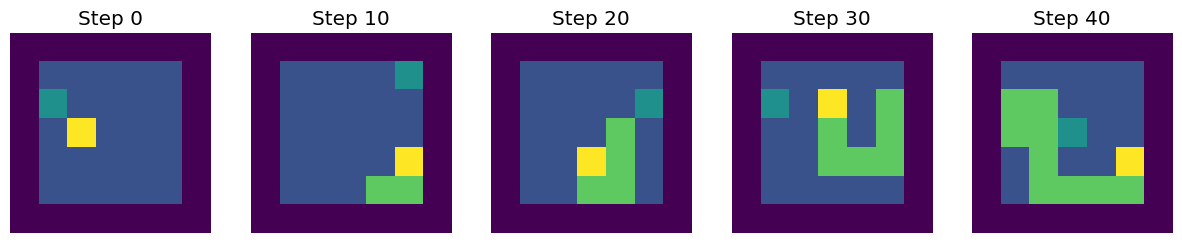

In [14]:
display_game(ppo_agent, max_steps=200)